### Image segmentation with CamVid

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [7]:
torch.cuda.set_device(1)

In [8]:
path=untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/deep/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/deep/.fastai/data/camvid/images'),
 PosixPath('/home/deep/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/deep/.fastai/data/camvid/labels')]

In [9]:
path_lbl=path/'labels'
path_img=path/'images'

### Data 

In [10]:
fnames=get_image_files(path_img)
fnames[:3]

[PosixPath('/home/deep/.fastai/data/camvid/images/0016E5_00750.png'),
 PosixPath('/home/deep/.fastai/data/camvid/images/0006R0_f00990.png'),
 PosixPath('/home/deep/.fastai/data/camvid/images/0016E5_07410.png')]

In [11]:
lbl_names=get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/deep/.fastai/data/camvid/labels/0001TP_009690_P.png'),
 PosixPath('/home/deep/.fastai/data/camvid/labels/0016E5_08073_P.png'),
 PosixPath('/home/deep/.fastai/data/camvid/labels/0016E5_04470_P.png')]

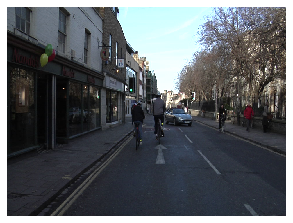

In [12]:
img_f=fnames[5]
img=open_image(img_f)
img.show(figsize=(5,5))

In [13]:
get_y_fn= lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

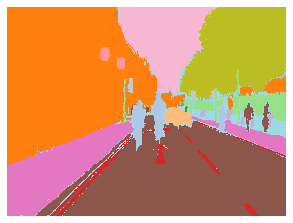

In [14]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [15]:
src_size=np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [16]:
codes=np.loadtxt(path/'codes.txt',dtype=str);codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

### Datasets

In [13]:
size=src_size//2
bs=8

In [21]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [22]:
data = (src.transform(get_transforms(), size=size,tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

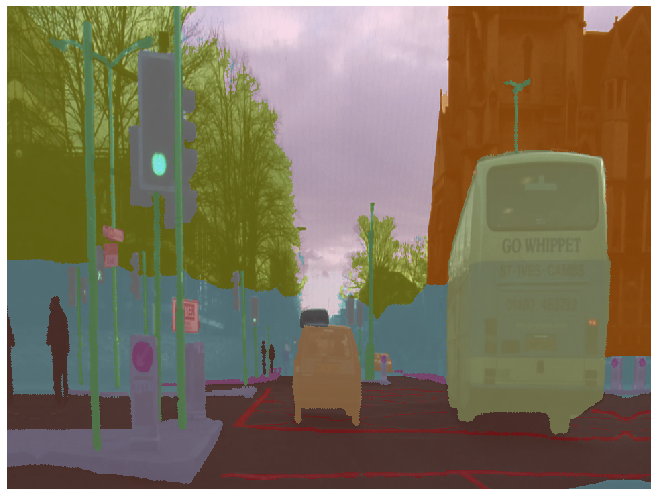

In [23]:
data.show_batch(2,figsize=(10,7))

### Model

In [24]:
name2id={v:k for k,v in enumerate(codes)}
void_code=name2id['Void']

def acc_camvid(input,target):
    target=target.squeeze(1)
    mask=target!=void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [29]:
metrics=acc_camvid
wd=1e-2

In [19]:
learn=unet_learner(data,models.resnet34,metrics=metrics,wd=wd, bottle=True).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


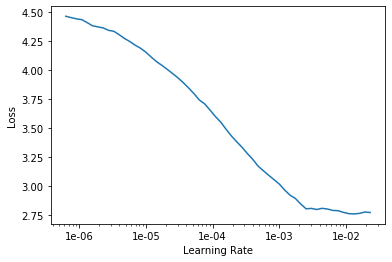

In [20]:
lr_find(learn)
learn.recorder.plot()

In [21]:
lr=1e-3

In [22]:
learn.fit_one_cycle(10,slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,1.391716,0.886033,0.795666,00:37
1,0.918456,0.720785,0.793927,00:35
2,0.838100,0.582741,0.839974,00:35
3,0.660115,0.512546,0.864874,00:35
4,0.565524,0.435290,0.873660,00:35
5,0.499022,0.402653,0.882341,00:35
6,0.441602,0.335530,0.906212,00:35
7,0.401848,0.334931,0.902735,00:35
8,0.362868,0.318760,0.907844,00:35
9,0.342851,0.306588,0.911653,00:35


In [23]:
learn.save('stage-1')

In [24]:
learn.load('stage-1');

In [25]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


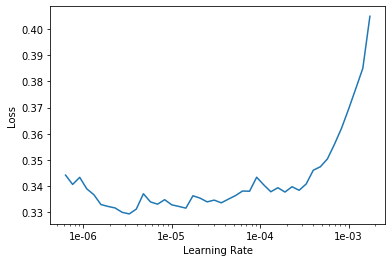

In [26]:
lr_find(learn)
learn.recorder.plot()

In [27]:
lrs=slice(1e-5,lr/5)

In [28]:
learn.fit_one_cycle(12,lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.337310,0.310366,0.910983,00:36
1,0.338927,0.316409,0.912266,00:37
2,0.347329,0.340913,0.892306,00:37
3,0.339100,0.330549,0.908483,00:37
4,0.316551,0.287508,0.917137,00:37
5,0.306807,0.289328,0.918074,00:37
6,0.286891,0.272207,0.921846,00:37
7,0.270909,0.266037,0.922814,00:37
8,0.261588,0.276895,0.921351,00:37
9,0.252470,0.276818,0.922871,00:37


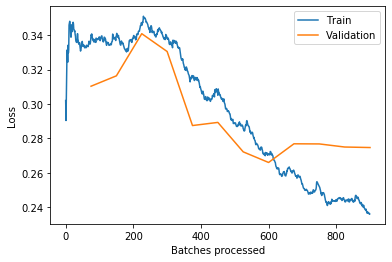

In [29]:
learn.recorder.plot_losses()

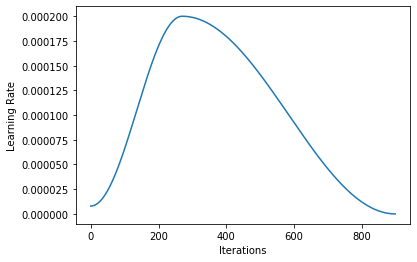

In [30]:
learn.recorder.plot_lr() #0.000200= maximum learning rate

In [ ]:
learn.save('stage-2');

### Go big

In [25]:
learn=None
gc.collect()

2354

In [26]:
size=src_size
bs=1

In [27]:
data=(src.transform(get_transforms(), size=size,tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [30]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


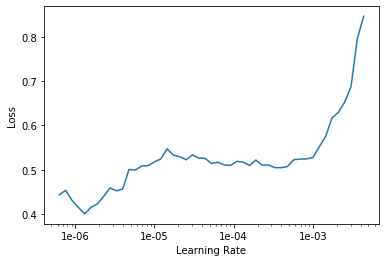

In [31]:
lr_find(learn)
learn.recorder.plot()

In [32]:
lr=0.5e-3

In [33]:
learn.fit_one_cycle(10,slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.415172,0.318549,0.910687,02:14
1,0.520827,0.471389,0.861859,02:19
2,0.479421,0.353585,0.903229,02:19
3,0.464464,0.366200,0.913767,02:19
4,0.344018,0.283891,0.922039,02:19
5,0.333165,0.248696,0.935999,02:19
6,0.276763,0.294990,0.922967,02:19
7,0.253290,0.243407,0.930977,02:19
8,0.204260,0.266239,0.928293,02:19
9,0.216807,0.256212,0.931353,02:19


In [34]:
learn.save('stage-2-big')

In [36]:
learn.load('stage-2-big');

In [37]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


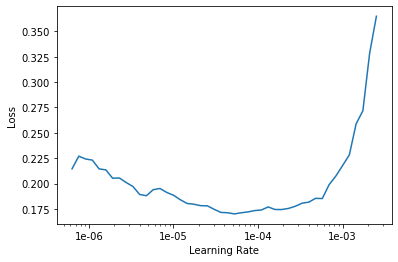

In [38]:
lr_find(learn)
learn.recorder.plot()

In [39]:
lrs=slice(1e-6,lr)

In [40]:
learn.fit_one_cycle(10,lrs,wd=1e-3)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.229694,0.255635,0.930363,02:26
1,0.288159,0.296873,0.924598,02:28
2,0.313439,0.292223,0.922362,02:27
3,0.265386,0.261898,0.926291,02:26
4,0.248649,0.273864,0.929835,02:27
5,0.219895,0.280996,0.924155,02:27
6,0.221803,0.276023,0.925680,02:27
7,0.179109,0.287215,0.924363,02:27
8,0.149847,0.258722,0.932619,02:27
9,0.166412,0.253419,0.933452,02:27


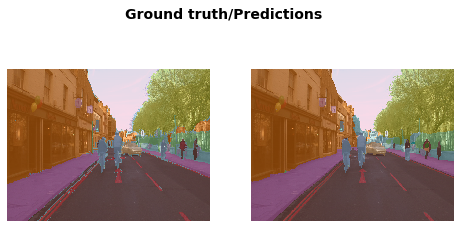

In [41]:
learn.show_results()